<a href="https://colab.research.google.com/github/ChapeuG/Projeto-Final-bootcamp/blob/main/Gabriel_Rodrigues_Projeto_Final_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Olá, Meu nome é Gabriel Rodrigues atualmente trabalho como analista de dados, sou estudante de Automação no Instituto Federal de Educação, Ciência e Tecnologia de São Paulo IFSP.

vocês podem estar me encontrando a partir:

*   [LinkedIn](https://www.linkedin.com/in/gabriel-rodrigues-5412b0177/)
*   [Portifólio](https://www.notion.so/Hello-there-38f739bbab02481197f7d0d539eb3156)
*   [GitHub](https://github.com/ChapeuG)


## Resumo:


SEJAM BEM VINDOS ao último mega desafio do Bootcamp!

Se ajeitem em suas cadeiras, preparem a pipoca e venham comigo mergulhar no mundo de dados.

![image.png](https://m.gifmania.pt/Gifs-Animados-Desportos/Imagens-Animadas-Mergulho/Gif-Animados-Divers/Divers-87642.gif)

___
O nosso Mega Desafio consistem em utilizar a base de dados sobre os pacientes do Sirio libanes, que foram ou não internados com COVID.

Sabemos que há urgência na obtenção e manipulação de dados para melhorar a previsão e assim, conseguir preparar o sistema de saúde, evitando colapsos.

Nosso objetivo será prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva e assim, definir qual a necessidade de leitos de UTI do hospital, a partir dos dados clínicos individuais disponíveis.

A equipe de Data Science do hospital Sírio Libanês disponibilizou no [Kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) informações de pacientes em Brasília e São Paulopara prever quais deles seriam ou não internados com base nas suas informações.
___

## Introdução



Identificado pela primeira vez em Dezembro de 2019, na China, a COVID-19 é uma doença causada pelo coronavirus que pegou o mundo inteiro de surpresa. Desde o começo da pandemia foram discutidas formas de achatar a distribuição de novos casos, para que os sistemas de saúde pudessem se preparar e impedir um possível colapso (falta de leitos, recursos humanos e EPIs para atender todos os pacientes).

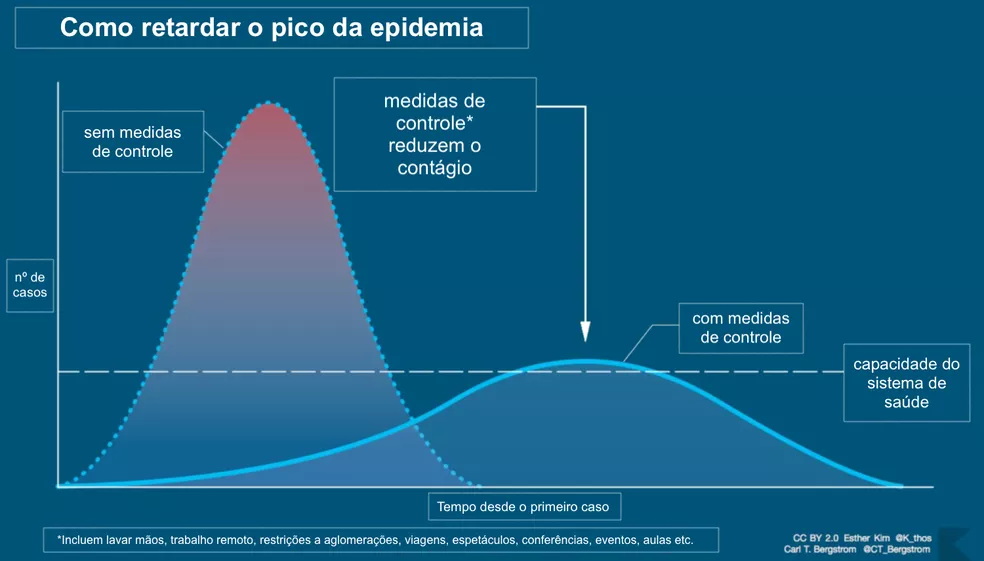

OBJETIVO

Nosso objetivo será prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva e assim, definir qual a necessidade de leitos de UTI do hospital, a partir dos dados clínicos individuais disponíveis.

## Preparando o "Terreno"


Essa sessão consiste em preparar o máximo do nosso dataset para realizar a análise exploratória, nela você leitor pode encontrar:

	

*   Bibliotecas importadas e instaladas 
*   Funções criadas para auxiliar o nosso código (meus agradecimentos a Marcela que me orientou em algumas delas)
* 	Nossa base e o tratamento nela realizado.

####Bibliotecas

In [1]:
#!pip install plotly

In [2]:
#Blibliotecas uteis
import pandas as pd
import numpy as np 

#abrir arquivo zip
import requests
from zipfile import ZipFile
from io import BytesIO
import zipfile

Gráficos

In [3]:
#!pip install plotly==4.14.3

In [4]:
#Gráficos
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Modelo

In [5]:
#Modelo
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, mutual_info_classif

####Funções

#####Tratamento e limpeza de dados

In [6]:
# instanciando labelencoder 
#labelencoder = LabelEncoder ()

In [7]:
#Função criada para abrir um arquivo zip
def ler_zip(url):
  r = requests.get(url , stream = True)
  z = ZipFile(BytesIO(r.content))
  file = z.extractall()
  return file

In [8]:
def preenche_tabela(dados):
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais

In [9]:
def prepara_janela(linhas):
  """Aplica o valor 1 na coluna ICU se em algum momento o paciente foi para a UTI
   e aplica a primeira janela para cada um dos pacientes
  """
  if(np.any(linhas['ICU'])):
    linhas.loc[linhas['WINDOW'] == '0-2',"ICU"] = 1
  return linhas.loc[linhas['WINDOW'] =='0-2']

In [10]:
#Função criada para informar as doenças pré-existentes
def trata_diseases(dados):
    new_dados = dados.copy()

    doencas = dados.columns[4:13] #seleciona apenas as colunas de doenças pré-existentes
    for doenca in doencas:
        gropby = dados.groupby(['PATIENT_VISIT_IDENTIFIER', doenca], as_index=False)[doenca].sum()\
                .groupby(['PATIENT_VISIT_IDENTIFIER'], as_index=False)[doenca].sum()

        new_dados[doenca] = dados['PATIENT_VISIT_IDENTIFIER'].map(gropby[doenca])
        new_dados.loc[new_dados[doenca] != 0, doenca] = 1
 
    return new_dados

In [11]:
#Função elabora para remover o excesso de colunas
def get_exames_keywords(dados):
    aux = dados.copy()
    colunas = aux.columns[13:-2] #apenas as colunas dos exames
    exames = []

    for col in colunas:
        exame = '_'.join(col.split('_')[:-1])
        exame = exame.replace('_DIFF','')
        if exame not in exames:
            exames.append(exame)

    return exames

def remove_colunas_redundantes(dados):
    exames = get_exames_keywords(dados)

    for exame in exames:
        cols_exame = dados.columns[dados.columns.str.startswith(exame)]
        cols_exame_sem_diff = np.delete(cols_exame, cols_exame.str.contains('DIFF')) #remove colunas DIFF

        r1 = dados[cols_exame_sem_diff].T.nunique() == 1

        if len(dados.T.columns[r1]) != 0:
            colunas_para_remover = cols_exame.tolist()
            colunas_para_remover.remove(f'{exame}_MEAN') # deixa apenas a coluna com final _MEAN
            dados = dados.drop(colunas_para_remover, axis=1)

    return dados

In [12]:
def a_remover(dados):
  a_remover = dados.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
  dados_limpos = dados.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
  dados_limpos = dados_limpos.dropna() #apagando linhas com valores faltantes
  return dados_limpos

#####Gráficos

In [13]:
def grafico_violin (dados,eixo_y,eixo_x,legenda,titulo):

  fig = px.violin(dados, y=eixo_y, x=eixo_x, color=legenda, box=True,
          hover_data=dados.columns)
  # Set figure title
  fig.update_layout(title_text=titulo,
                      width = 445, height = 400,
                      autosize = True)

  return fig.show()

In [14]:
def set_figure(fig, titulo, largura=800, altura=600, x_label='', y_label=''):
    fig.update_layout(
        template = 'plotly_white',

        #configurando título e nome dos eixos
        title_text = titulo,        
        xaxis_title_text = x_label,
        yaxis_title_text = y_label,
        
        #configurando posição da legenda
        legend=dict(title='', orientation="h", y=0.96,
                    yanchor="bottom", xanchor="right", x = 1),

        #configurando e fixando o tamanho do gráfico
        autosize=False,
        width=largura,
        height=altura,
    )

In [15]:
def subplot_count_plot_bar(eixo_x, df, subplots, linhas, colunas,titulo):
   
    fig = make_subplots(rows=linhas, cols=colunas, subplot_titles=subplots)
    
    for i, col in enumerate(subplots):
        df_aux = df[df[col] == 1].groupby(eixo_x,
                        as_index=False)['PATIENT_VISIT_IDENTIFIER'].agg('count')

        fig.add_trace(go.Bar(x=df_aux[eixo_x],
                                y=df_aux['PATIENT_VISIT_IDENTIFIER'],
                                text=df_aux['PATIENT_VISIT_IDENTIFIER'],
                                textposition='auto',
                                name=col,
                                showlegend=False),
                        row=int(i/colunas+1), col=int(i%colunas+1))
    fig.update_layout(height=950, width=900, title_text=titulo)
    return fig

In [16]:
class PlotBoxR(object):
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [17]:
def plot_matriz_conf(y_test, y_predict, titulo):
    z = confusion_matrix(y_test, y_predict)
    fig = ff.create_annotated_heatmap(z=z[::-1],
                                      x=['Não', 'Sim'],
                                      y=['Sim', 'Não'],
                                      colorscale='Viridis',
                                      showscale=True)

    fig.update_xaxes(title_standoff = 0)
    fig.update_yaxes(title_standoff = 0)
    fig['layout']['xaxis']['side'] = 'bottom'

    # Set figure title
    fig.update_layout(title_text=f"Matriz de confusão modelo{titulo}",
                      
                      width = 445, height = 400,
                      autosize = False)

    fig.update_xaxes(
        title_text = "Internação - Previsão",
        title_font = {"size": 20},
        title_standoff = 25)

    fig.update_yaxes(
        title_text ="Internação - Real",
        title_standoff = 25)


    fig.show()

#####Modelo

In [18]:
#Função criada para verificar o Score dos modelos
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [19]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 10
    scoring = 'accuracy'

    results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=num_folds, random_state=SEED)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [20]:
# Função para usar N modelos no meu projeto
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LogisticRegression()))
    basedModels.append(('KNN'  , KNeighborsClassifier()))
    basedModels.append(('CART' , DecisionTreeClassifier()))
    basedModels.append(('NB'   , GaussianNB()))
    basedModels.append(('RF'   , RandomForestClassifier()))
    
    return basedModels

In [21]:
#Função criada para acompanhar meu pipeline e rodar N modelos standard
def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LogisticRegression())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsClassifier())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeClassifier())])))
    pipelines.append((nameOfScaler+'NB'  , Pipeline([('Scaler', scaler),('NB'  , GaussianNB())])))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestClassifier())])  ))
    
    return pipelines 

In [22]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [23]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        clf = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 )
        # Fit randomized search
        best_model = clf.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

###Base de dados

In [24]:
ler_zip('https://github.com/ChapeuG/Projeto-Final-bootcamp/blob/main/Dados/Kaggle_Sirio_Libanes_ICU_Prediction.zip?raw=true')

In [25]:
dados = pd.read_excel('/content/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

#### Breve explicação dos dados

Descrição da janela

Em nosso dataset podemos ter até 5 linhas por paciente onde cada uma delas vai representar os dados agregado por janelas em ordem cronológica.


---



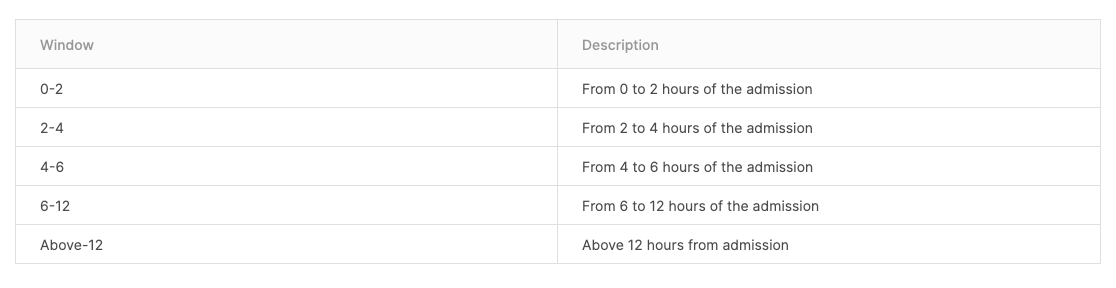



---


Também encontramos diversos tipos de informações que foram separadas em 4 grupos com dados que correspondem a janela de internação do paciente :

1.   Informação demográfica - 3 variáveis
2.   Doenças pré-existentes - 9 variáveis
3.   Resultados do exame de sangue - 36 variáveis
4.   Sinais vitais - 6 variáveis



Outro ponto impornate, segundo as informações do Sirio, não devemos usar os dados da janela onde o paciente foi internado,visto que esses dados podem aprensentar imprecisões em relação a sua janela.

exemplo:

Se o paciente foi internado na Janela 2-4 só vamos usar os dados da Janela de 0-2
<img alt="" src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2F77ca2b4635bc4dd7800e1c777fed9de1%2FTimeline%20Example%20No.png?generation=1594740873237462&amp;alt=media">

<img alt="" src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1591620%2Fb1bc424df771a4d2d3b3088606d083e6%2FTimeline%20Example%20Best.png?generation=1594740856017996&amp;alt=media">



### Tratamento dos dados

É sempre bom definir uma semente para reprodutibilidade em outros ambientes

In [26]:
SEED = 722053
np.random.seed(SEED)

Nessa Sessão eu invoco algumas funções para limpar a base.

![image.png](https://64.media.tumblr.com/1bd372afd6d13f750027c1dfe307f204/tumblr_mtxvg2HZ2z1sjhmx6o1_500.gif)

**trata_diseases**

Essa função me retorna em todas janelas se aquele paciente já possuui alguma doença Pré existente.

Antes:

In [27]:
dados[dados['PATIENT_VISIT_IDENTIFIER'] == 20]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
100,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.965463,-0.965463,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
101,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.037037,-0.553846,-0.547170,NaN,-0.250000,0.842105,-0.037037,-0.553846,-0.547170,NaN,-0.250000,0.842105,0.134021,-0.2625,-0.401709,NaN,0.230769,0.939394,-0.333333,-0.686486,-0.641791,NaN,-0.391304,0.842105,-1.000000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,2-4,0
102,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.234568,-0.784615,-0.377358,-0.593220,0.142857,0.894737,-0.234568,-0.784615,-0.377358,-0.586207,0.142857,0.894737,-0.030928,-0.4500,-0.247863,-0.500000,0.472527,0.959596,-0.470085,-0.848649,-0.507463,-0.636364,-0.072464,0.894737,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
103,20,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,0.736842,NaN,NaN,NaN,NaN,0.571429,0.736842,NaN,NaN,NaN,NaN,0.736264,0.898990,NaN,NaN,NaN,NaN,0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
104,20,0,40th,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.984427,-1.0,0.023497,-0.501489,-0.178637,-0.518863,0.165899,0.668081,0.086420,-0.461538,-0.198113,-0.517241,0.178571,0.684211,-0.175258,-0.5625,-0.538462,-0.571429,0.120879,0.777778,0.076923,-0.308108,0.014925,0.151515,0.391304,1.000000,-0.321739,-0.276074,-0.206107,-0.176471,-0.238095,-0.777778,-0.491304,-0.194281,-0.448553,-0.146953,-0.250518,-0.775609,ABOVE_12,0


Depois:

In [28]:
dados = trata_diseases(dados)
dados[dados['PATIENT_VISIT_IDENTIFIER'] == 20]

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
100,20,0,40th,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.965463,-0.965463,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
101,20,0,40th,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.037037,-0.553846,-0.547170,NaN,-0.250000,0.842105,-0.037037,-0.553846,-0.547170,NaN,-0.250000,0.842105,0.134021,-0.2625,-0.401709,NaN,0.230769,0.939394,-0.333333,-0.686486,-0.641791,NaN,-0.391304,0.842105,-1.000000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN,-1.000000,-1.000000,2-4,0
102,20,0,40th,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.234568,-0.784615,-0.377358,-0.593220,0.142857,0.894737,-0.234568,-0.784615,-0.377358,-0.586207,0.142857,0.894737,-0.030928,-0.4500,-0.247863,-0.500000,0.472527,0.959596,-0.470085,-0.848649,-0.507463,-0.636364,-0.072464,0.894737,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
103,20,0,40th,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.571429,0.736842,NaN,NaN,NaN,NaN,0.571429,0.736842,NaN,NaN,NaN,NaN,0.736264,0.898990,NaN,NaN,NaN,NaN,0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
104,20,0,40th,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.984427,-1.0,0.023497,-0.501489,-0.178637,-0.518863,0.165899,0.668081,0.086420,-0.461538,-0.198113,-0.517241,0.178571,0.684211,-0.175258,-0.5625,-0.538462,-0.571429,0.120879,0.777778,0.076923,-0.308108,0.014925,0.151515,0.391304,1.000000,-0.321739,-0.276074,-0.206107,-0.176471,-0.238095,-0.777778,-0.491304,-0.194281,-0.448553,-0.146953,-0.250518,-0.775609,ABOVE_12,0


A coluna 'AGE_PERCENTIL' se encontra com valores do tipo object, vou realizar a conversão para o tipo numerico.

In [29]:
dados.dtypes

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

In [30]:
dict_AGE = {
    '10th': 10,
    '20th': 20,
    '30th': 30,
    '40th': 40,
    '50th': 50,
    '60th': 60,
    '70th': 70,
    '80th': 80,
    '90th': 90,
    'Above 90th':100
}

dados['AGE'] = dados['AGE_PERCENTIL'].map(dict_AGE)
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,AGE
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,60
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,60
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0,60
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0,60
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.2422

Realizo o mesmo processo para o ICU, esse processo tem mais utilidade em simplificar a visualização em um gráfico do que em uma análise.

In [31]:
dict_ICU = {
    0: 'Não',
    1: 'Sim'
}

dados['INTERNADX'] = dados['ICU'].map(dict_ICU)
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,AGE,INTERNADX
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,60,Não
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,60,Não
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0,60,Não
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0,60,Não
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.8

Como temos as informações de doenças em todas as janelas, posso trabalhar somente com os pacientes únicos, ou seja, 1 linha por paciente.

In [32]:
pacientes_unicos = dados.query("WINDOW=='ABOVE_12'")
print(f'Continuamos com {len(pacientes_unicos["PATIENT_VISIT_IDENTIFIER"].unique())} e '\
                             f'{pacientes_unicos.shape[0]} janelas.' )

Continuamos com 385 e 385 janelas.


Caso queira validar os dados dos gráficos pode baixar a planilha.

In [33]:
pacientes_unicos.to_excel("pacientes_unicos.xlsx")

## 2. Análise exploratória:


### Analise por idade

In [34]:
fig = px.violin(pacientes_unicos, y="AGE", x="GENDER", color="INTERNADX", box=True, points="all",
          hover_data=pacientes_unicos.columns)
fig.show()

Como foi informado desde o início da pandemia e como podemos ver nos gráficos as pessoas mais velhas são as mais propicias a serem internadas e podemos notar que o gênero 1 foi mais suscetível a ser internados.

Como não temos como identificar o gênero, podem ser somente uma análise observatório que não tenha relevância.


### Analise por Grupo de Doença

In [35]:
Grupo_doenca = ['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
           'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6',
           'HTN', 'IMMUNOCOMPROMISED', 'OTHER']

In [36]:
titulo="Quantidade de pessoas por idade que possui alguma doença Pré existente"
fig = subplot_count_plot_bar('AGE_PERCENTIL', df=pacientes_unicos,
                            subplots=Grupo_doenca,
                            linhas=3, colunas=3,titulo=titulo)
fig.show()

Acima podemos ter de forma mais visivel a distribuição de pessoas por idade em relação as doenças pré existentes, como foi dito anteriormente pessoas de idade mais avançadas estão mais sucetiveis a serem iternadas, porém nao devemos esquecer das pessoas do grupo de risco.

A grande maioria de pessoas que possui alguma doença se encontra na casa ~~(de aries)~~  acima dos 60 anos, mas temos exceções de pessoas mais jovens que podem ou não acabar internadas. 



In [37]:
titulo='Quantidade de pessoas internadas por grupo de doença'
fig = subplot_count_plot_bar('INTERNADX', df=pacientes_unicos,
                            subplots=Grupo_doenca,
                            linhas=3, colunas=3,titulo=titulo)
fig.show()

A maior quantidade de pessoas internadas se encontram nas outras doenças, logo após temos o grupo de HTN(pressão alta) a de  imunocomprometidos(são aqueles cujos mecanismos normais de defesa contra infecção estão comprometidos.)

### Analise por Grupo de Exames

In [38]:
grupo_exames = ['BLOODPRESSURE_DIASTOLIC_MEAN','BLOODPRESSURE_SISTOLIC_MEAN',
                'RESPIRATORY_RATE_MEAN','TEMPERATURE_MEAN','OXYGEN_SATURATION_MEAN','HEART_RATE_MEAN']

In [39]:
titulo='Diferença de resultados de internados ou não por grupo de Exames'
c = 2
fig = make_subplots(cols=c, rows=int(len(grupo_exames)/c+1), subplot_titles=grupo_exames)
for i, col in enumerate(grupo_exames):
  fig.add_trace(go.Box(x=dados['INTERNADX'],y=pacientes_unicos[col],
                             showlegend=False),
                      row=int(i/c)+1, col=int(i%c)+1)
fig.update_layout(height=950, width=900, title_text=titulo)
fig.update_yaxes(categoryorder='array', categoryarray= ['0-2','2-4','4-6','6-12',
                                                        'ABOVE_12','NO_ICU'])
fig.show()

Podemos notar que o nosso Q3(75%) do *RESPIRATORY_RATE* ficou acima da média daqueles que não ficaram internados, olhando de uma forma macro, as diferenças entre aqueles que foram ou não internados se dá por pequenas casas decimais. 

Essa diferença na visão de um especialista na área da saúde pode ser um fator determinante para internar ou não o paciente.

## 3. Construção do Modelo:


###Tratando e preparando os dados para o Modelo

Removendo todos os pacientes que foram internados na primeira janela

In [40]:
a_remover = dados.query('WINDOW == "0-2" and ICU == 1')['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados.query('PATIENT_VISIT_IDENTIFIER not in @a_remover').reset_index(drop=True)

dados_limpos.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU,AGE
count,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,...,739.000000,739.0,1108.000000,1108.000000,1112.000000,1053.000000,1103.000000,1111.000000,1108.000000,1108.000000,1112.000000,1053.000000,1103.000000,1111.000000,1108.000000,1108.000000,1112.000000,1053.000000,1103.000000,1111.000000,1108.000000,1108.000000,1112.000000,1053.000000,1103.000000,1111.000000,1108.000000,1108.000000,1112.000000,1053.000000,1103.000000,1111.000000,1108.000000,1108.000000,1112.000000,1053.000000,1103.000000,1111.000000,1765.000000,1765.000000
mean,192.835694,0.456091,0.379603,0.150142,0.050992,0.144476,0.028329,0.158640,0.070822,0.288952,0.178470,1.0,0.531835,0.531835,0.531835,0.531835,-1.0,-0.968956,-0.968956,-0.968956,-0.968956,-1.0,-0.935253,-0.935253,-0.935253,-0.935253,-1.0,-0.311825,-0.311825,-0.311825,-0.311825,-1.0,-0.311198,-0.311198,-0.311198,-0.311198,-1.0,-0.945439,-0.945439,-0.945439,...,-0.954718,-1.0,-0.086462,-0.341436,-0.267437,-0.457331,0.068163,0.742565,-0.091568,-0.347397,-0.271014,-0.453581,0.064920,0.747193,-0.030221,-0.207807,-0.265157,-0.494505,0.330896,0.821309,-0.235212,-0.412265,-0.285555,-0.344384,0.014204,0.815647,-0.761639,-0.742453,-0.757565,-0.721133,-0.775375,-0.892071,-0.796061,-0.729520,-0.819947,-0.733648,-0.776424,-0.891971,0.201133,52.662890
std,110.481302,0.498209,0.485426,0.357311,0.220043,0.351671,0.165957,0.365444,0.256599,0.453404,0.383017,0.0,0.221484,0.221484,0.221484,0.221484,0.0,0.157706,0.157706,0.157706,0.157706,0.0,0.164827,0.164827,0.164827,0.164827,0.0,0.098026,0.098026,0.098026,0.098026,0.0,0.117697,0.117697,0.117697,0.117697,0.0,0.080469,0.080469,0.080469,...,0.127610,0.0,0.249208,0.262912,0.245603,0.204720,0.233554,0.126840,0.254543,0.266209,0.251693,0.212627,0.240383,0.124015,0.275648,0.267688,0.270206,0.260486,0.202740,0.276231,0.264852,0.274265,0.294689,0.391530,0.270529,0.140752,0.352054,0.389952,0.361589,0.466468,0.308266,0.288869,0.311507,0.402389,0.267913,0.433956,0.306903,0.289193,0.400961,28.882085
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.

Verificando se houve alteração na quantidade de pacientes

In [41]:
print(f'{len(dados["PATIENT_VISIT_IDENTIFIER"].unique())} pacientes '\
      f'{dados.shape[0]} janelas.')

385 pacientes 1925 janelas.


In [42]:
print(f'{len(dados_limpos["PATIENT_VISIT_IDENTIFIER"].unique())} pacientes '\
      f'{dados_limpos.shape[0]} janelas.')

353 pacientes 1765 janelas.


Vou eliminar algumas colunas que acabam sendo redundantes para nosso modelo

In [43]:
print('Antes: ', dados_limpos.shape)
dados_limpos_e_completos = remove_colunas_redundantes(dados_limpos)
print('Depois: ', dados_limpos_e_completos.shape)

Antes:  (1765, 233)
Depois:  (1765, 89)


Tratando valores nulos

In [44]:
dados_limpos_e_completos = preenche_tabela(dados_limpos)
dados_limpos_e_completos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,AGE,INTERNADX
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0,60,Não
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0,60,Não
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0,60,Não
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.11450

In [45]:
dados_limpos_e_completos.isnull().sum()

PATIENT_VISIT_IDENTIFIER      0
AGE_ABOVE65                   0
AGE_PERCENTIL                 0
GENDER                        0
DISEASE GROUPING 1            0
                             ..
OXYGEN_SATURATION_DIFF_REL    0
WINDOW                        0
ICU                           0
AGE                           0
INTERNADX                     0
Length: 233, dtype: int64

### PIPELINES 



![image.png](https://miro.medium.com/max/275/1*t1g--SEw98yvEGeLDwamUw.gif)

Pipelines são importantes para manter a Reprodutibilidade em qualquer ambiente ou para qualquer pessoa que vá usar do seu projeto.

Mas, e se for algo que estou fazendo só para mim mesmo e não vou compartilhar com ninguém? Você deve estar se perguntando. Muito provavelmente você vai compartilhar ela com pelo menos uma pessoa: o seu EU do futuro!

A Pipeline simplifica muito a organização do seu código, fazendo com que outras pessoas, incluindo o seu EU do futuro, consigam ler e entender mais facilmente.

Perfeito para ambientes de produção que estão "vivos" (em constante desenvolvimento ou alterações)

![image.png](https://miro.medium.com/max/480/1*a-sumPrmWNWqpHcqNh6LKA.gif)

In [46]:
x_columns = dados_limpos_e_completos.columns
x_columns = x_columns.drop(["ICU","WINDOW",'AGE_PERCENTIL','INTERNADX'])
x_pip = dados_limpos_e_completos[x_columns]
y_pip = dados_limpos_e_completos["ICU"]
X_train_pip, X_test_pip, y_train_pip, y_test_pip = train_test_split(x_pip, y_pip)
print("Teste e Treino separados")

Teste e Treino separados


In [47]:
pip_1 = Pipeline([                 
    ('scaler', StandardScaler()),
    ('min_max_scaler', MinMaxScaler()),
    ('standardscaler', StandardScaler()),
    ('clf', DecisionTreeClassifier(max_depth = 3,random_state = 0))
])

In [48]:
pip_1.steps

[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('min_max_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('clf',
  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                         max_depth=3, max_features=None, max_leaf_nodes=None,
                         min_impurity_decrease=0.0, min_impurity_split=None,
                         min_samples_leaf=1, min_samples_split=2,
                         min_weight_fraction_leaf=0.0, presort='deprecated',
                         random_state=0, splitter='best'))]

In [49]:
pip_1.fit(X_train_pip,y_train_pip)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('min_max_scaler',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=3,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=0,
                                        splitter='best

In [50]:
acuracia = pip_1.score(X_test_pip, y_test_pip)
acuracia

0.8710407239819005

In [51]:
y_predict_pip = pip_1.predict(X_test_pip)

In [52]:
confusion_matrix(y_test_pip, y_predict_pip)
plot_matriz_conf(y_test_pip, y_predict_pip,'DecisionTreeClassifier PIPELINE')

Fim, acabamos o projeto e até a proxima pessoal.

![image.png](https://media.giphy.com/media/1FT20zgiDr8Bi/giphy.gif)

---



Sem mais brincadeiras, só queria demonstrar como podemos aplicar no mundo corporatvo a pipelines e como elas facilitam a construção de um modelo.

Agora vamos colocar a mão na massa!

![image.png](https://miro.medium.com/max/940/1*jpqy1dXi-s0z_4XTJGco1w.gif)

###Feature Selection
Feature Importance

É a seleção automática de atributos em seus dados (como colunas em dados tabulares) que são mais relevantes para o problema de modelagem preditiva em que você está trabalhando.

Os métodos de seleção de recursos ajudam em sua missão de criar um modelo preditivo preciso. Eles ajudam na escolha de recursos que fornecerão uma precisão tão boa ou melhor, ao mesmo tempo que exigem menos dados.

Os métodos de seleção de recursos podem ser usados ​​para identificar e remover atributos desnecessários, irrelevantes e redundantes de dados que não contribuem para a precisão de um modelo preditivo ou podem de fato diminuir a precisão do modelo.


---

> Resumindo é uma das formas de catar feijão como diria Carlos Drummond, peneirar suas colunas para escolher as melhores colunas para o seu modelo.
---


Nessa sessão eu uso dois metodos o SelectKBest e a RFE:

> RFE: — Recursive Feature Elimination — , o RFE funciona da seguinte forma: ele irá treinar seu modelo utilizando todo seu conjunto inicial, com todas as features e data points que vierem nele. Após o primeiro treino, o RFE irá verificar a importância das features.
>utilizando atributos como *coef_* ou *feature_importances_* e, recursivamente, irá remover as features menos importantes do dataset e treinar o modelo novamente. Ele fará isso até chegar a um número ideal de features.

>SelectKBest: Uma outra forma de selecionar features é através de testes estatítisticos univariados. A função SelectKBest do sklearn é um bom exemplo disso. Seu funcionamento é bem simples: você informa para a função que quer selecionar apenas as K maiores features do seu dataset com base em um teste estatístico.







____
SelectKBest

In [53]:
dados_limpos_e_completos.set_index('PATIENT_VISIT_IDENTIFIER', inplace=True)
remove = ["ICU","WINDOW",'AGE_PERCENTIL','Internadx']

In [54]:
x_columns = dados_limpos_e_completos.columns
x_columns = x_columns.drop(["ICU","WINDOW",'AGE_PERCENTIL','INTERNADX'])
x = dados_limpos_e_completos[x_columns]
y = dados_limpos_e_completos["ICU"]
X_train, X_test, y_train, y_test = train_test_split(x, y)
print("Teste e Treino separados")

Teste e Treino separados


In [55]:
dados_limpos_e_completos.shape

(1765, 232)

In [56]:
f_classif = SelectKBest(score_func=f_classif, k=50)
fit = f_classif.fit(x,y)
features = fit.transform(x)
# Visualizando as features:
print(features)

[[ 1.         -1.         -1.         ... -1.         -1.
  60.        ]
 [ 1.         -1.         -1.         ... -1.         -1.
  60.        ]
 [ 1.         -1.         -1.         ... -1.         -1.
  60.        ]
 ...
 [ 0.         -1.         -1.         ... -1.         -1.
  50.        ]
 [ 0.         -1.         -1.         ... -1.         -1.
  50.        ]
 [ 0.         -1.         -1.         ... -0.55133725 -0.83505155
  50.        ]]


In [57]:
cols = fit.get_support(indices=True)
colunas_selecionadas = dados_limpos_e_completos.iloc[:,cols]
colunas_selecionadas.head()

,AGE_ABOVE65,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,HEMATOCRITE_DIFF,HEMOGLOBIN_MEDIAN,HEMOGLOBIN_MEAN,HEMOGLOBIN_MIN,INR_DIFF,LACTATE_MEDIAN,LACTATE_MEAN,LACTATE_MIN,LACTATE_DIFF,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LINFOCITOS_DIFF,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,TTPA_DIFF,UREA_MEDIAN,UREA_MEAN,UREA_MIN,DIMER_DIFF,HEART_RATE_MEAN,OXYGEN_SATURATION_MEAN,HEART_RATE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_SISTOLIC_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0.109756,0.109756,0.109756,-1.0,1.000000,1.000000,1.000000,-1.0,-0.835844,-0.835844,-0.835844,-1.0,-0.868747,-0.868747,-0.868747,-1.0,-0.836145,-0.836145,-0.836145,-1.0,-0.283019,0.736842,-0.283019,0.736842,0.0000,-0.500000,0.208791,-0.247863,-0.459459,-0.432836,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0,1,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0.109756,0.109756,0.109756,-1.0,1.000000,1.000000,1.000000,-1.0,-0.835844,-0.835844,-0.835844,-1.0,-0.868747,-0.868747,-0.868747,-1.0,-0.836145,-0.836145,-0.836145,-1.0,-0.132075,0.578947,-0.132075,0.578947,0.0000,-0.500000,0.714286,-0.076923,-0.459459,-0.313433,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
0,1,-1.0,-1.000000,-1.000000,-1.000000,-1.0,0.109756,0.109756,0.109756,-1.0,1.000000,1.000000,1.000000,-1.0,-0.835844,-0.835844,-0.835844,-1.0,-0.868747,-0.868747,-0.868747,-1.0,-0.836145,-0.836145,-0.836145,-1.0,-0.213031,0.736842,-0.188679,0.736842,-0.4875,-0.857143,0.318681,-0.076923,0.286486,0.298507,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000
0,1,-1.0,-0.863874,-0.863874,-0.863874,-1.0,-0.353659,-0.353659,-0.353659,-1.0,-0.963023,-0.963023,-0.963023,-1.0,-0.762843,-0.762843,-0.762843,-1.0,-0.868747,-0.868747,-0.868747,-1.0,-0.836145,-0.836145,-0.836145,-1.0,-0.213031,0.736842,-0.188679,0.736842,-0.4875,-0.857143,0.318681,-0.076923,0.286486,0.298507,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000
0,1,-1.0,-0.863874,-0.863874,-0.863874,-1.0,-0.353659,-0.353659,-0.353659,-1.0,-0.963023,-0.963023,-0.963023,-1.0,-0.762843,-0.762843,-0.762843,-1.0,-0.868747,-0.868747,-0.868747,-1.0,-0.836145,-0.836145,-0.836145,-1.0,-0.213031,0.665932,-0.188679,0.631579,-0.4875,-0.857143,0.098901,-0.076923,0.286486,0.298507,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433


In [58]:
print(f'Foram selcionadas {colunas_selecionadas.shape[1]} Colunas de {dados_limpos_e_completos.shape[1]}. \n \n'
      f'As colunas selecionadas foram {colunas_selecionadas.columns}')

Foram selcionadas 50 Colunas de 232. 
 
As colunas selecionadas foram Index(['AGE_ABOVE65', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_MEDIAN',
       'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'INR_DIFF', 'LACTATE_MEDIAN',
       'LACTATE_MEAN', 'LACTATE_MIN', 'LACTATE_DIFF', 'LEUKOCYTES_MEDIAN',
       'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN', 'LINFOCITOS_DIFF',
       'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MIN',
       'TTPA_DIFF', 'UREA_MEDIAN', 'UREA_MEAN', 'UREA_MIN', 'DIMER_DIFF',
       'HEART_RATE_MEAN', 'OXYGEN_SATURATION_MEAN', 'HEART_RATE_MEDIAN',
       'OXYGEN_SATURATION_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MIN',
       'RESPIRATORY_RATE_MIN', 'TEMPERATURE_MIN',
       'BLOODPRESSURE_DIASTOLIC_MAX', 'BLOODPRESSURE_SISTOLIC_MAX',
       'HEART_RATE_MAX', 'TEMPERATURE_MAX', 'OXYGEN_SATURATION_MAX',
       'BLOODPRESSURE_DIASTOLIC_DIFF', 'BLOODPRESSURE_SISTOLIC_DIFF',
       'HEART_RATE_DIFF', 'RESPIR

___
RFE

In [59]:
model = LogisticRegression(max_iter=2000)

rfe = RFE(model, 50,step=3)
fit = rfe.fit(x, y)

# Mostrando o número de features:
print ("Número de features: {}".format(fit.n_features_))  

Número de features: 50


In [60]:
# Visualizando os índices:
cols = fit.get_support(indices=True)
colunas_selecionadas_RFE = dados_limpos_e_completos.iloc[:,cols]
colunas_selecionadas_RFE.head()

,AGE_PERCENTIL,GENDER,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BILLIRUBIN_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_MEAN,CREATININ_MIN,FFA_MEAN,FFA_MIN,PH_ARTERIAL_DIFF,PH_VENOUS_DIFF,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_MEAN,POTASSIUM_MIN,SAT02_VENOUS_MIN,TGP_DIFF,TTPA_MEDIAN,TTPA_MEAN,TTPA_MIN,UREA_MIN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,HEART_RATE_MEDIAN,OXYGEN_SATURATION_MEDIAN,RESPIRATORY_RATE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,TEMPERATURE_DIFF_REL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,60th,0,0.0,0.0,0.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-0.938950,-1.0,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-1.0,-1.0,-1.0,-0.518519,-0.518519,-0.518519,0.345679,-1.0,-0.825613,-0.825613,-0.825613,-0.836145,-1.0,0.086420,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.283019,0.736842,-0.500000,0.898990,-0.247863,-0.432836,-0.636364,-0.420290,-1.000000,-1.000000,-1.000000
0,60th,0,0.0,0.0,0.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-0.938950,-1.0,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-1.0,-1.0,-1.0,-0.518519,-0.518519,-0.518519,0.345679,-1.0,-0.825613,-0.825613,-0.825613,-0.836145,-1.0,0.333333,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.132075,0.578947,-0.500000,0.838384,-0.076923,-0.313433,-0.636364,0.246377,-1.000000,-1.000000,-1.000000
0,60th,0,0.0,0.0,0.0,-1.0,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-0.938950,-1.0,-0.868365,-0.868365,-0.868365,-0.742004,-0.742004,-1.0,-1.0,-1.0,-0.518519,-0.518519,-0.518519,0.345679,-1.0,-0.825613,-0.825613,-0.825613,-0.836145,-1.0,-0.243021,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.188679,0.736842,-0.857143,0.898990,-0.076923,0.298507,0.272727,-0.275362,-1.000000,-0.230462,-1.000000
0,60th,0,0.0,0.0,0.0,-1.0,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.979069,-1.0,-0.926398,-0.926398,-0.926398,-0.859275,-0.859275,-1.0,-1.0,-1.0,-0.666667,-0.666667,-0.666667,0.925926,-1.0,-0.846633,-0.846633,-0.846633,-0.836145,-1.0,-0.243021,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.188679,0.736842,-0.857143,0.898990,-0.076923,0.298507,0.272727,-0.275362,-1.000000,-0.230462,-1.000000
0,60th,0,0.0,0.0,0.0,-1.0,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.979069,-1.0,-0.926398,-0.926398,-0.926398,-0.859275,-0.859275,-1.0,-1.0,-1.0,-0.666667,-0.666667,-0.666667,0.925926,-1.0,-0.846633,-0.846633,-0.846633,-0.836145,-1.0,-0.243021,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.188679,0.631579,-0.857143,0.797980,-0.076923,0.298507,0.272727,0.362319,-0.818182,-0.230462,-0.242282


In [61]:
print(f'Foram selcionadas {colunas_selecionadas_RFE.shape[1]} Colunas de {dados_limpos_e_completos.shape[1]}. \n \n'
      f'As colunas selecionadas foram {colunas_selecionadas_RFE.columns}')

Foram selcionadas 50 Colunas de 232. 
 
As colunas selecionadas foram Index(['AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN',
       'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BILLIRUBIN_MEDIAN', 'CALCIUM_DIFF', 'CREATININ_MEDIAN',
       'CREATININ_MEAN', 'CREATININ_MIN', 'FFA_MEAN', 'FFA_MIN',
       'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF',
       'POTASSIUM_MEDIAN', 'POTASSIUM_MEAN', 'POTASSIUM_MIN',
       'SAT02_VENOUS_MIN', 'TGP_DIFF', 'TTPA_MEDIAN', 'TTPA_MEAN', 'TTPA_MIN',
       'UREA_MIN', 'DIMER_DIFF', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'HEART_RATE_MEAN', 'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN',
       'OXYGEN_SATURATION_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'HEART_RATE_MEDIAN', 'OXYGEN_SATURATION_MEDIAN', 'RESPIRATORY_RATE_MIN',
       'OXYGEN_SATURATION_MIN', 'BLOODPRE

Vamos comparar quais colunas se encontram nas duas selecões

In [62]:
set(colunas_selecionadas.columns).intersection(set(colunas_selecionadas_RFE.columns))

{'BE_ARTERIAL_DIFF',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MIN',
 'BLOODPRESSURE_DIASTOLIC_MAX',
 'DIMER_DIFF',
 'HEART_RATE_DIFF_REL',
 'HEART_RATE_MAX',
 'HEART_RATE_MEAN',
 'HEART_RATE_MEDIAN',
 'OXYGEN_SATURATION_DIFF',
 'OXYGEN_SATURATION_MEAN',
 'OXYGEN_SATURATION_MEDIAN',
 'RESPIRATORY_RATE_MIN',
 'TEMPERATURE_DIFF_REL',
 'TEMPERATURE_MAX',
 'UREA_MIN'}

###Modelo COM SELEÇÃO FEATURES

Eu optei por usar a seleção do RFE para meu modelo.

In [63]:
lista_colunas = list(colunas_selecionadas_RFE.columns)
lista_colunas.append('ICU')
colunas_selecionadas_RFE_com_icu = dados_limpos_e_completos[lista_colunas]

In [64]:
x_columns = colunas_selecionadas_RFE_com_icu.columns.drop(["ICU",'AGE_PERCENTIL'])
x_SF = colunas_selecionadas_RFE_com_icu[x_columns]
y_SF = colunas_selecionadas_RFE_com_icu["ICU"]
X_train_SF, X_test_SF, y_train_SF, y_test_SF =train_test_split(x_SF,y_SF,
                                                   stratify = y_SF)

print("Teste e Treino separados")

Teste e Treino separados


No gráfico abaixo eu crio um boxplot para validar a acurácia dos meus modelos.

In [65]:
models = GetBasedModel()
names,results = BasedLine2(X_train_SF, y_train_SF,models)
PlotBoxR().PlotResult(names,results)

LR: 0.878332 (0.022140)
KNN: 0.859421 (0.019432)
CART: 0.837543 (0.031765)
NB: 0.839001 (0.017294)
RF: 0.888141 (0.016420)


Os dois modelos que obtiveram o maior score com base na acuracia foi o **RandomForestClassifier** e o **LogisticRegression** por isso vou usar ambos para criar a matriz de confusão.

In [66]:
#definindo Parâmetros
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

In [67]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

model_RamdomF = RandomForestClassifier()
RandomF_RandSearch = RandomSearch(X_train_SF,y_train_SF,model_RamdomF,param_grid)
Prediction_RandomF = RandomF_RandSearch.BestModelPridict(X_test_SF)
print('Score da previsão do conjunto de teste é:' ,( round((y_test_SF == Prediction_RandomF).mean(),3)))

Best: 0.884370 using {'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 1}
Score da previsão do conjunto de teste é: 0.88


In [68]:
# model
model = LogisticRegression()
# Criar espaço de penalidade de regularização
penalty = ['l1', 'l2']

# Criando distribuição de hiperparâmetros de regularização usando distribuição uniforme
C = uniform(loc=0, scale=4)

# Criando opções de hiperparâmetros
hyperparameters = dict(C=C, penalty=penalty)

In [69]:
LR_RandSearch = RandomSearch(X_train,y_train,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR = LR_RandSearch.BestModelPridict(X_test)
print('Score da previsão do conjunto de teste é:',(round((y_test == Prediction_LR).mean(),3)))

Best: 0.887378 using {'C': 0.07952053535918235, 'penalty': 'l2'}
Score da previsão do conjunto de teste é: 0.851


Analises matriz de confusão modelos RandomForestClassifier e LogisticRegression

In [70]:
confusion_matrix(y_test, Prediction_RandomF)
plot_matriz_conf(y_test, Prediction_RandomF,' RandomForestClassifier')

confusion_matrix(y_test, Prediction_LR)
plot_matriz_conf(y_test, Prediction_LR,' LogisticRegression')

plot_matriz_conf(y_test_pip, y_predict_pip,' PIPELINE')

Podemos analisar que conforme adicionamos mais parâmetros dentro dos nossos modelos, o modelo de Logistic Regression passou o modelo Random Forest Classifier em questão da previsão de quem seria ou não internados, segundo nossa matriz de confusão. 

Podemos entender que quanto mais calibramos nosso modelo, maior será a chance de chegar ao número de ideal ou possui uma margem de erro baixa.

Contudo nosso modelo criado no PIPELINE segue tendo os melhores valores, eu acredito que isso se dá pela maior quantidade de informação ou por colunas que foram removidas da seleção que no modelo da Pipeline foram decisivas para sua previsão.
___


###Modelo Sem a seleção de FEATURES

In [71]:
dados_limpos_e_completos.reset_index(inplace=True)

In [72]:
x_columns = dados_limpos_e_completos.columns
x_columns = x_columns.drop(["ICU","WINDOW",'AGE_PERCENTIL','INTERNADX'])
x = dados_limpos_e_completos[x_columns]
y = dados_limpos_e_completos["ICU"]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x, y)

Criando novamento o  boxplot para validar a acurácia dos meus modelos.

In [74]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)

LR: 0.878287 (0.016525)
KNN: 0.800507 (0.031525)
CART: 0.827660 (0.026220)
NB: 0.819350 (0.025159)
RF: 0.885857 (0.023612)


In [75]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

,Model,Score
0,LR,0.8783
1,KNN,0.8005
2,CART,0.8277
3,NB,0.8193
4,RF,0.8859


Criando novamente o  boxplot para validar a acurácia dos meus modelos usando o Standard Scaler, que transforma os dados e os coloca na mesma escala. 

Você pode ler mais sobre na documentação [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

In [76]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train,models)
PlotBoxR().PlotResult(names,results)
scaledScoreStandard = ScoreDataFrame(names,results)

standardLR: 0.867681 (0.022979)
standardKNN: 0.865425 (0.016037)
standardCART: 0.834461 (0.018091)
standardNB: 0.819350 (0.025159)
standardRF: 0.884336 (0.024968)


In [77]:
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

,Model,Score,Model,Score
0,LR,0.8783,standardLR,0.8677
1,KNN,0.8005,standardKNN,0.8654
2,CART,0.8277,standardCART,0.8345
3,NB,0.8193,standardNB,0.8193
4,RF,0.8859,standardRF,0.8843


Abaixo eu crio uma tabela fazendo um rank dos melhores modelos com base em sua acurácia.

In [90]:
Rank_modelos = pd.concat([basedLineScore,scaledScoreStandard],ignore_index=False).sort_values('Score',ascending=False)

In [91]:
Rank_modelos.reset_index(drop=True)
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0,
    specs=[[{"type": "table"}],
           [{"type": "scatter"}]])

fig.add_trace(
    go.Bar(
        x=Rank_modelos['Model'],
        y=Rank_modelos['Score']
    ),
    row=2, col=1
)
fig.add_trace(
    go.Table(
        header=dict(
            values=['Model','Score'],
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[Rank_modelos[k].tolist() for k in Rank_modelos.columns[:]],
            align = "left")
    ),
    row=1, col=1
)

fig.update_layout(
    height=650,
    title_text="Texto",
)

Eu escolhi 3 modelos para realizar a previsão e sua matriz de confusão sendo eles 



1.   Primeiro lugar o Random Forest Classifier por ter atingido o maior score.
2.   Um modelo que ficou no meio dos dois sendo ele Decision Tree.
3. Ultimo lugar KNeighbors Classifier por ter tido o menor escore.

(Futuramente pretendo realizar a validação em todos os modelos )



####KNeighborsClassifier

In [80]:
model_KNN = KNeighborsClassifier()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
param_grid = dict(n_neighbors=neighbors)

In [81]:
KNN_GridSearch = GridSearch(X_train,y_train,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test)
print('Score da previsão do conjunto de teste é:' ,((y_test == Prediction_KNN).mean(),7))
confusion_matrix(y_test, Prediction_KNN)

Best: 0.826145 using {'n_neighbors': 1}
Score da previsão do conjunto de teste é: (0.8235294117647058, 7)


array([[315,  30],
       [ 48,  49]])

In [82]:
plot_matriz_conf(y_test, Prediction_KNN,'KNeighborsClassifier')
plot_matriz_conf(y_test_pip, y_predict_pip,' PIPELINE')

O modelo da pipeline consegue ficar na frente por pequenos valores, o ponto mais importante que vejo para escolher é a quantidade de pacientes internados sim ou não, onde teve uma diferença de 3 pacientes (não sim), ou seja, mandou o paciente que seria internado embora.

Mas isso requer uma análise muito mais profunda.

#### Decision Tree

In [83]:
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)
criterion_value = ["gini", "entropy"]

In [84]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [85]:
model_Decision = DecisionTreeClassifier()
CART_RandSearch = RandomSearch(X_train,y_train,model_Decision,param_grid)
Prediction_CART = CART_RandSearch.BestModelPridict(X_test)
print('Score da previsão do conjunto de teste é:' ,((y_test == Prediction_CART).mean(),7))
confusion_matrix(y_test, Prediction_CART)

Best: 0.845050 using {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 3}
Score da previsão do conjunto de teste é: (0.7850678733031674, 7)


array([[310,  35],
       [ 60,  37]])

In [86]:
plot_matriz_conf(y_test, Prediction_CART,'DecisionTreeClassifier')
plot_matriz_conf(y_test_pip, y_predict_pip,' PIPELINE')

O modelo de DecisionTreeClassifier ao receber a calibragem de seus parâmetros apresentou resultados piores do que o KNeighbors Classifier, um dos fatores pode ser a própria calibragem quanto mais parâmetros maior a chance do modelo ser melhor ou pior. 

#### RandomForestClassifier

In [87]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value,
                  criterion = criterion_value)

In [88]:
model_RamdomF = RandomForestClassifier()
RandomF_RandSearch = RandomSearch(X_train,y_train,model_RamdomF,param_grid)
Prediction_RandomF = RandomF_RandSearch.BestModelPridict(X_test)
print('Score da previsão do conjunto de teste é:' ,((y_test == Prediction_RandomF).mean(),7))
confusion_matrix(y_test, Prediction_RandomF)

Best: 0.880554 using {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3}
Score da previsão do conjunto de teste é: (0.8597285067873304, 7)


array([[337,   8],
       [ 54,  43]])

In [89]:
plot_matriz_conf(y_test, Prediction_RandomF,'RandomForestClassifier')
plot_matriz_conf(y_test_pip, y_predict_pip,' PIPELINE')

E por fim o melhor modelo vs o da nossa pipeline.

Ao realizar uma analise o modelo pipeline apresenta um melhor resultado para sua previsão de quem não deveria ser internado e na realidade foi, contudo o inverso de pessoas que ele previu que seriam internadas e não foram apresenta um numero maior que o do Random Forest.

## 4. Conclusão


Concluindo o projeto e minha análise posso colocar como pontos importantes:

* A importância da análise exploratória, ou seja, entender seus dados, o que eles representam e como se conversam.
* Como o tratamento de dados ajuda a prevenir possíveis erros no futuro, desde valores nulos a dados “duplicados” (que no caso seriam as janelas de cada paciente).
*	A importância de selecionar features a fim de escolher as melhores para o se modelo.
*	E como devemos treinar e aplicar mais de um score em nosso modelo ou entender qual o melhor score que se aplica a ele. 
*	Calibrar nossos modelos, como ocorreu em meu projeto ao inserir parâmetros tive uma melhora de modelos que tiveram uma acurácia baixa como tive o inverso acurácia alta e ao inserir parâmetros tiveram um desempenho ruim.

Caso queria escolher o modelo ideal deve se atender aos um falso negativo que significa mandar um paciente para casa quando na verdade ele precisaria de um leito de UTI.

Um falso negativo seria é muito pior que um falso positivo (colocar um paciente que não precisa de leito em um leito), visto que a consequência seria o óbito do paciente.

Porém devemos nos atentar a não sobrecarregar o sistema de saúde, reservando leitos para aqueles que não precisam. 

Ou seja, o modelo ideal é aquele que possui valores baixos para falso negativo e médios para falso positivo.


____
O modelo da pipeline tem valores bons para o falso negativo e falso positivo, porém podemos ir calibrando o modelo Random Forest que apresentou baixos falso positivo para apresentar baixos falso positivo


## 4. Considerações


Apesar de não ter atingido todos meus objetivos, consegui apresentar pontos importantes da minha análise e modelos. 

Já deixo passos futuros caso você leitor ou o meu eu do futuro volte nesse projeto. 

*   Melhorar o storytelling do projeto
*   Aprimorar a seleção de features
*   Criar métricas para o modelo
*   Analisar se maior o tempo do paciente, maior a chance de ser contaminado com covid 